# Concepts Extraction for Hack 11 

- http://www.tiernok.com/posts/automated-keyword-extraction-tf-idf-rake-and-textrank.html (RAKE, TF-IDF, Text Rank)

In [1]:
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import json
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
filepath = "/Users/tmagalhaes/Projects/Hack11"
filename = "companies_100_reviews.csv"

In [3]:
df = pd.read_csv(filepath+"/"+filename, sep='|', names=["id", "company_name", "pros", "cons"])
df = df.dropna()

In [4]:
df.head(10)

,id,company_name,pros,cons
0,432410,Capgemini,Easily get into the job.,To get Pay hike and bonuses if any
1,432535,Bank of Queensland,It was close to home.,Management and leadership
2,435148,Air Liquide,It was a great family organization until 2 yea...,Low remuneration. No salary increases in over ...
3,434562,Don KRC,Geting a pay each week ; thats all ; nothing g...,Trying to do every persons job ; cause other p...
4,433198,Converga,Working through the clouds and work associates...,everyday new challenges
5,432535,Bank of Queensland,It's a small bank that tries to focus on custo...,Training is poor; large staff turnover because...
6,432324,Monadelphous,Well organised job. Good tooling and stores.,Push to work in rain.
7,432441,Coca-Cola Amatil,They take safety serious,We all need after customers
8,432775,Fantastic Furniture,other staff and customers,trying to advance and senior management at hea...
9,433112,Michael Hill Jeweller,Meeting wonderful people and making their enga...,Meeting targets for the week. Some weeks are ...


In [5]:
df.groupby(['id', 'company_name']).agg({"pros": 'count'})[:10]

pros
id     company_name                       
432324 Monadelphous                  83741
432368 The University of Queensland   7196
       University of Queensland      21591
432402 Skilled Group                 22901
432410 Capgemini                     12310
432423 RailCorp                       9271
432441 Coca-Cola Amatil              39673
432456 Microsoft                     11927
432496 Chicken Treat                  5390
432514 BAE Systems                   35056

In [8]:
companies_reviews_count = df.groupby(['id'], as_index=False)['company_name'].count()
companies_reviews_count.rename(columns={'company_name': 'Total Reviews', 'id': 'Company ID'}, inplace=True)
companies_reviews_count.set_index('Company ID', inplace=True)
companies_reviews_count = companies_reviews_count.sort_values(by="Total Reviews", ascending=False)
companies_reviews_count.describe()

,Total Reviews
count,100.000000
mean,12658.520000
std,11604.504149
min,5078.000000
25%,6463.750000
50%,8328.000000
75%,13768.000000
max,83741.000000


In [9]:
companies_high_reviews = list(companies_reviews_count.reset_index()['Company ID'][:5])
companies_high_reviews

[432324, 432746, 432600, 432441, 432514]

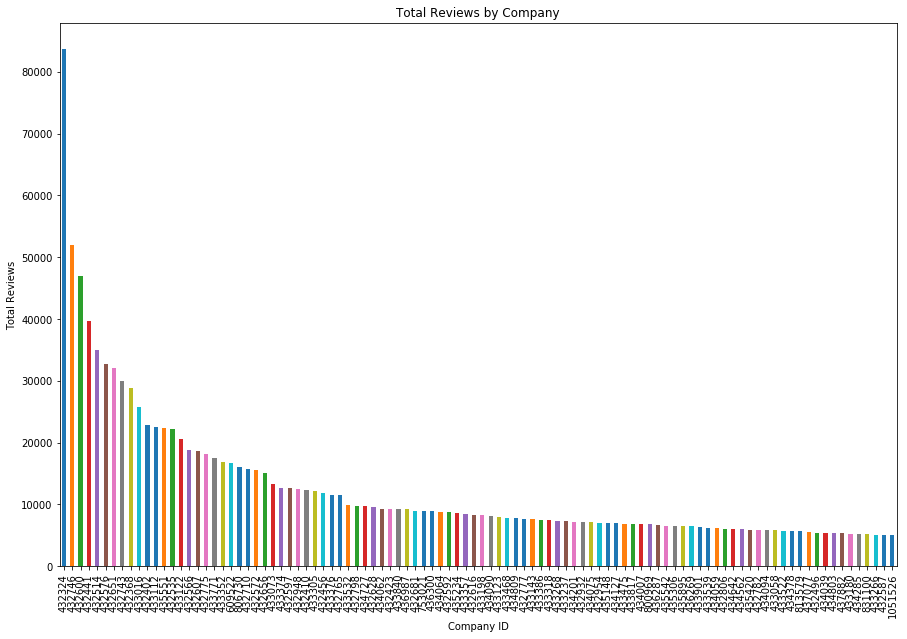

In [10]:
fig, ax = plt.subplots(figsize=[15,10])
ax.set_ylabel("Total Reviews")
companies_reviews_count.sort_values(by="Total Reviews", ascending=False)['Total Reviews'].plot(kind='bar', ax=ax, title="Total Reviews by Company")

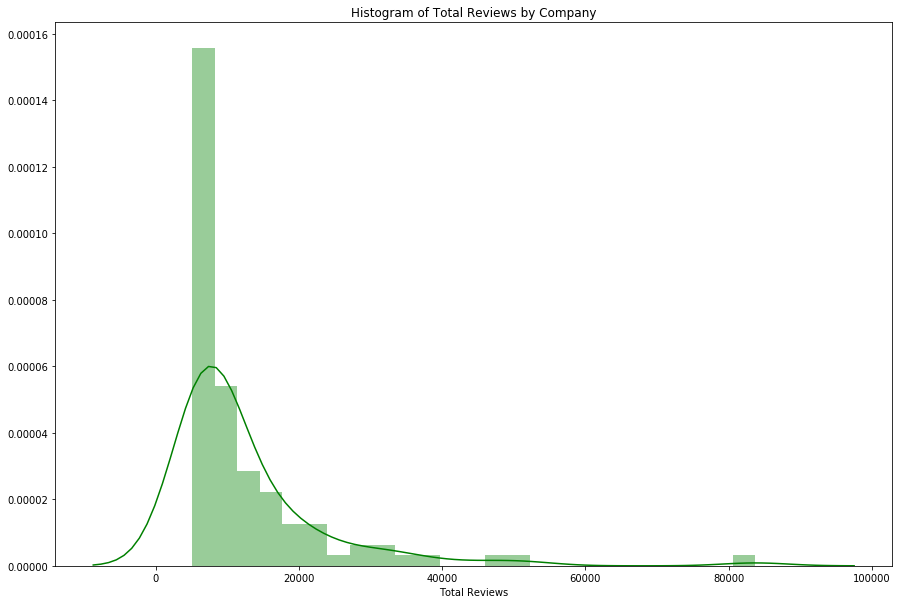

In [11]:
fig, ax = plt.subplots(figsize=[15,10])
ax.set_title("Histogram of Total Reviews by Company")
sns.distplot(companies_reviews_count['Total Reviews'], ax=ax, color='green', kde=True)

# Concepts Extraction using RAKE

In [12]:
# RAKE
# https://pdfs.semanticscholar.org/5a58/00deb6461b3d022c8465e5286908de9f8d4e.pdf
# pip3 install python-rake - https://github.com/fabianvf/python-rake
import RAKE
rake = RAKE.Rake(RAKE.NLTKStopList())

def extract_keywords(review, min_score=0.0):
    global rake
    kw_list = []
    kws = rake.run(review, minCharacters=2, maxWords=3, minFrequency=1)
    for kw, score in kws:
        if score >= min_score:
            kw_list.append((kw, round(score,2)))
    return kw_list

In [13]:
# extracted_df = df[df['id'].isin(companies_high_reviews)]
extracted_df = df.copy() # Getting for all companies
extracted_df = extracted_df.sort_values(by='company_name')
extracted_df.reset_index(inplace=True)
extracted_df.rename(columns={'index': 'review_id'}, inplace=True)
extracted_df['review_id'] = extracted_df['review_id'].apply(lambda x: int(x))
extracted_df.head(10)

,review_id,id,company_name,pros,cons
0,274063,432777,AAMI,They pay really well if you get good stats.,You don't get any personal time to go to the t...
1,107606,432777,AAMI,The pay and the people working there.,Management. The targets. Customers.
2,346994,432777,AAMI,Flexible rosters Work life balance,Changes all the time with management and their...
3,700558,432777,AAMI,Very friendly and good service,Solving people demands in a quick and positive...
4,1098227,432777,AAMI,It is a nice working environment & the people ...,The work is repetitive & there needs to be mor...
5,107583,432777,AAMI,Supportive environment; good social life; work...,Lack of career progression opportunities; low ...
6,945760,432777,AAMI,The pay and the people working there.,Management. The targets. Customers.
7,561537,432777,AAMI,Diversity of staff; working from home and work...,Customers constantly screaming at you on the p...
8,510344,432777,AAMI,Working for AAMI (Suncorp) has been the best d...,Every position has its downs; AAMI provides a ...
9,700466,432777,AAMI,The incredible staff I worked with,KPA's


In [15]:
extracted_df['concepts'] = extracted_df['pros'].apply(lambda x: extract_keywords(x))
extracted_df.drop('cons', axis=1, inplace=True)
extracted_df.rename(columns={'id': 'company_id', 'pros': 'review'}, inplace=True)

In [16]:
extracted_df.head()

,review_id,company_id,company_name,review,concepts
0,274063,432777,AAMI,They pay really well if you get good stats.,"[(pay really well, 9.0), (get good stats, 9.0)]"
1,107606,432777,AAMI,The pay and the people working there.,"[(people working, 4.0), (pay, 1.0)]"
2,346994,432777,AAMI,Flexible rosters Work life balance,[]
3,700558,432777,AAMI,Very friendly and good service,"[(good service, 4.0), (friendly, 1.0)]"
4,1098227,432777,AAMI,It is a nice working environment & the people ...,"[(bonuses & room, 4.0), (move onto, 4.0), (peo..."


In [23]:
# Export to file
filename = "companies_reviews_extracted_concepts.json"
extracted_df.to_json(filepath+"/"+filename, orient='records')

In [18]:
# Another approach to try:
# Text Rank
# https://github.com/davidadamojr/TextRank
# https://github.com/tarwn/bookmark_analysis/blob/master/exploration/v2/textrank.py